In [ ]:
import preprocessing 
import importlib
import utilities
import technical_indicators as technical_indicators
import tensorflow as tf
import numpy as np
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
from keras import Sequential
from tensorflow import keras
from visualisation import plot_multiline_chart
from utilities import plot_actual_vs_predicted, get_actual_and_predicted


# TSLA

In [14]:
from utilities import TimeSeries, min_max_scale
from technical_indicators import ( calculate_adx, calculate_rsi, calculate_rolling_std, calculate_rolling_mean, calculate_rolling_returns, intra_day_range, fit_trendline )
tsla = TimeSeries('TSLA', date="2000-01-01").shift_column('Close', -5, True).construct_technical_indicators(
        [       
            calculate_rsi,
            intra_day_range,
            calculate_adx,
            calculate_rolling_std,
            calculate_rolling_mean,
            calculate_rolling_returns,
            fit_trendline
        ],
        [25, 50],
).lag_column('Close', 0, 200).drop_columns(['Date','Open', 'High', 'Low', 'Adj Close', 'Close']).dropna().train_test_split(test_size=0.2, target='Close_Ahead_5')

[*********************100%%**********************]  1 of 1 completed


In [16]:
def penalise_underprediction_more (y_true, y_pred):
    penalty_factor = 5.0  # You can adjust this value based on your preference
    absolute_error = tf.abs(y_true - y_pred)
    loss = tf.where(y_true >= y_pred, penalty_factor * absolute_error, absolute_error)
    return tf.reduce_mean(loss, axis=-1)

def train_model_lstm (ticker: TimeSeries, epochs: int, units_lstm=100, act_fun="relu", hp_lr=1e-6):
    keras.backend.clear_session()
    input_data_x = ticker.get_reshaped_X_for_LSTM(which_data='train', min_max_scale=True)
    input_data_y = min_max_scale(ticker, which_data='y')

    model = Sequential()
    model.add(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            input_shape=ticker.input_feature_shape,
        )
    )
    model.add(LSTM(units=units_lstm, return_sequences=False, activation="relu"))
    model.add(Dense(units=50, activation='linear'))
    model.add(Dense(units=20, activation=act_fun))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss=penalise_underprediction_more
    )
    return model.fit(
        input_data_x,
        input_data_y[0],
        epochs=epochs,
        batch_size=32,
        verbose=2,
    )
lstm_tsla = train_model_lstm(tsla, 200, 100, "relu", 1e-5)

Epoch 1/200


c:\Users\kumar\miniconda3\envs\darn\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 - 2s - 25ms/step - loss: 0.9174
Epoch 2/200
84/84 - 0s - 2ms/step - loss: 0.8747
Epoch 3/200
84/84 - 0s - 2ms/step - loss: 0.8254
Epoch 4/200
84/84 - 0s - 2ms/step - loss: 0.7552
Epoch 5/200
84/84 - 0s - 2ms/step - loss: 0.6519
Epoch 6/200
84/84 - 0s - 2ms/step - loss: 0.5043
Epoch 7/200
84/84 - 0s - 2ms/step - loss: 0.3193
Epoch 8/200
84/84 - 0s - 2ms/step - loss: 0.1749
Epoch 9/200
84/84 - 0s - 2ms/step - loss: 0.1495
Epoch 10/200
84/84 - 0s - 2ms/step - loss: 0.1317
Epoch 11/200
84/84 - 0s - 2ms/step - loss: 0.1137
Epoch 12/200
84/84 - 0s - 2ms/step - loss: 0.1012
Epoch 13/200
84/84 - 0s - 2ms/step - loss: 0.0932
Epoch 14/200
84/84 - 0s - 2ms/step - loss: 0.0868
Epoch 15/200
84/84 - 0s - 2ms/step - loss: 0.0815
Epoch 16/200
84/84 - 0s - 2ms/step - loss: 0.0769
Epoch 17/200
84/84 - 0s - 2ms/step - loss: 0.0729
Epoch 18/200
84/84 - 0s - 2ms/step - loss: 0.0700
Epoch 19/200
84/84 - 0s - 2ms/step - loss: 0.0671
Epoch 20/200
84/84 - 0s - 2ms/step - loss: 0.0647
Epoch 21/200
84/84 -

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


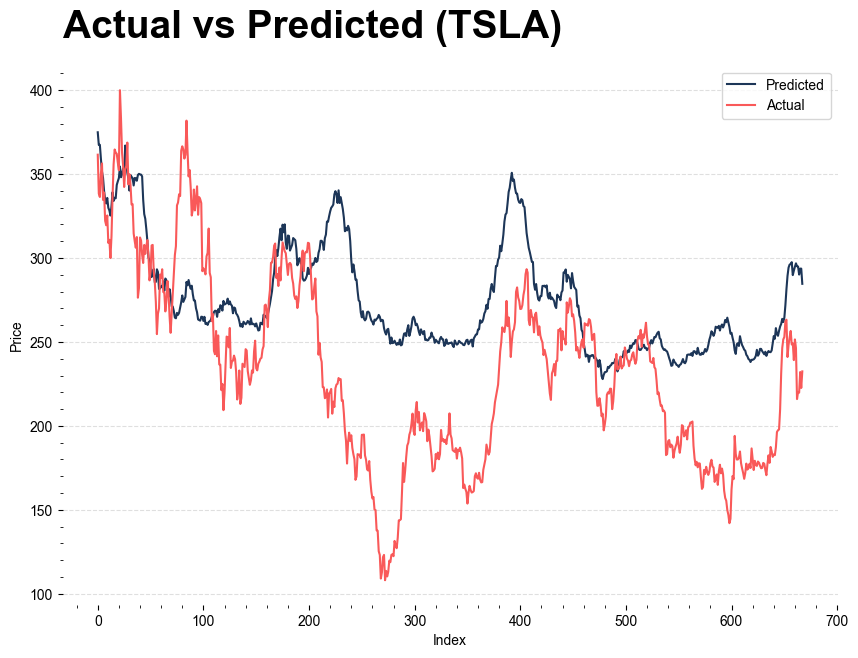

In [18]:
plot_actual_vs_predicted(tsla, lstm_tsla, "Actual vs Predicted (TSLA)")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
Buy and Hold Return: 0.6430126590270863
Strategy Return: 0.8109578326040741


C:\Users\kumar\AppData\Local\Temp\ipykernel_13052\1758966469.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Net Portfolio Value'].iloc[i] = df['Net Portfolio Value'].iloc[i - 1]
C:\Users\kumar\AppData\Local\Temp\ipykernel_13052\1758966469.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Net Portfolio Value'].iloc[i] = df['Net Portfolio Value'].iloc[i - 1]
C:\Users\kumar\AppData\Local\Temp\ipykernel_13052\1758966469.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

<module 'matplotlib.pyplot' from 'c:\\Users\\kumar\\miniconda3\\envs\\darn\\Lib\\site-packages\\matplotlib\\pyplot.py'>

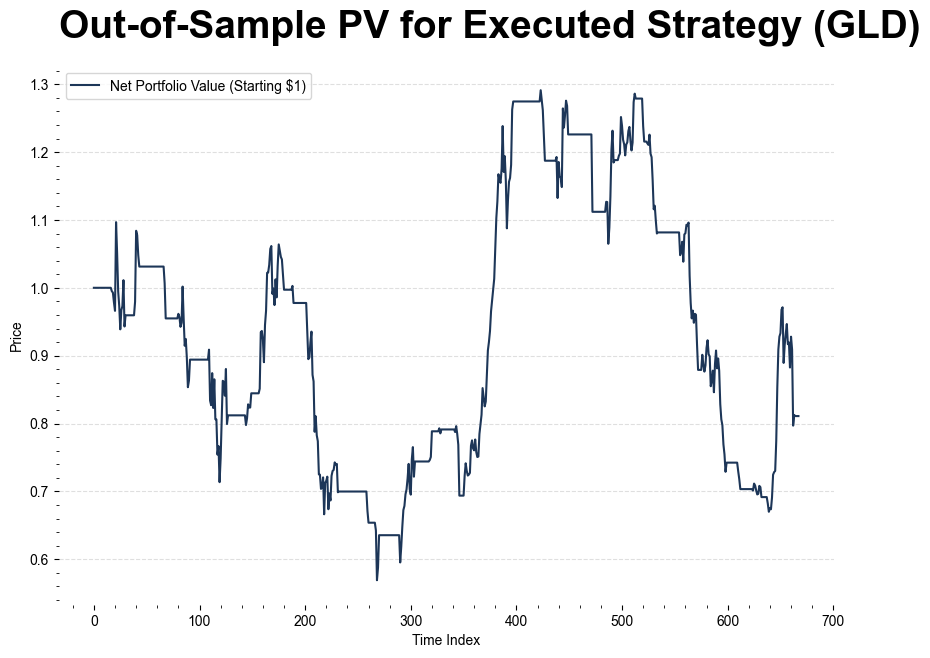

In [19]:
import pandas as pd


def get_buy_and_hold_return (ticker: TimeSeries):
    price_vector = ticker.training_data.y_test
    return price_vector[-1] / price_vector[0]

def get_strategy_dataframe (ticker: TimeSeries, model, smooth_window=20, choppy_window=5):
    df = pd.DataFrame({"Actual":get_actual_and_predicted(ticker, model).actual, "Predicted":get_actual_and_predicted(ticker, model).predicted})
    df['Predicted_MA_Choppy'] = df['Predicted'].rolling(window=choppy_window).mean()
    df['Predicted_MA_Smooth'] = df['Predicted'].rolling(window=smooth_window).mean()
    df['Buy'] = df['Predicted_MA_Choppy'] > df['Predicted_MA_Smooth']
    df['Net Portfolio Value'] = 1.0  # Starting with $1.0

    for i in range(1, len(df)):
        if df['Buy'].iloc[i - 1]:  # If Buy is True in the previous row
            df['Net Portfolio Value'].iloc[i] = df['Net Portfolio Value'].iloc[i - 1] * (df['Actual'].iloc[i] / df['Actual'].iloc[i - 1])
        else:
            df['Net Portfolio Value'].iloc[i] = df['Net Portfolio Value'].iloc[i - 1]
    return df


tsla_strat = get_strategy_dataframe(tsla, lstm_tsla, 10, 4)
print(f"Buy and Hold Return: {get_buy_and_hold_return(tsla)}")
print(f"Strategy Return: {tsla_strat['Net Portfolio Value'].iloc[-1]}")
plot_multiline_chart([(tsla_strat.index, tsla_strat['Net Portfolio Value'], "Net Portfolio Value (Starting $1)")], "Out-of-Sample PV for Executed Strategy (GLD)", "Time Index", "Price")


In [21]:
print(f"Buy and Hold Return: {get_buy_and_hold_return(tsla)}")
print(f"Strategy Return: {tsla_strat['Net Portfolio Value'].iloc[-1]}")

Buy and Hold Return: 0.6430126590270863
Strategy Return: 0.8109578326040741
